<a href="https://colab.research.google.com/github/bylehn/auxetic_networks_jaxmd/blob/abhishek/test-auxetic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax.numpy as np
from jax import random
from jax.config import config; config.update("jax_enable_x64", True)
from jax_md import space, energy, minimize, simulate, quantity
from jax import random
from jax import jit
import networkx as nx
import numpy as onp
from scipy.spatial import Delaunay
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
#modification
def plot_configuration(node_positions, bond_array, box_size):
    # Create an empty plot
    fig, ax = plt.subplots()

    # Plot the node positions
    for i, position in enumerate(node_positions):
        ax.scatter(position[0], position[1], s=50, c='red', label='Node')

    # Plot the bonds
    for bond in bond_array:
        start_node = node_positions[bond[0]]
        end_node = node_positions[bond[1]]
        ax.plot([start_node[0], end_node[0]], [start_node[1], end_node[1]], 'b-', linewidth=2, label='Bond')


    # Customize the plot
    ax.set_xlim(0, box_size)
    ax.set_ylim(0, box_size)

    # Show the plot
    plt.show()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
def createDelaunayGraph(NS, rseed, r_c, del_x):

    # This function creates a Delaunay graph of a set of points.

    # Parameters:
    #   NS: The number of points to generate.
    #   rseed: The random seed to use.
    #   r_c: The radius of the circumcircle of each edge in the graph.
    #   del_x: max noise magnitude from square lattice

    # Returns:
    #   N: The number of points in the graph.
    #   G: The graph object.
    #   X: The coordinates of the points.
    #   E: The edges of the graph.

    # Set the random seed.
    onp.random.seed(rseed)

    # Generate the points.
    xm, ym = onp.meshgrid(onp.arange(1, NS + 1), onp.arange(1, NS + 1))
    X = onp.vstack((xm.flatten(), ym.flatten())).T
    N = X.shape[0]

    # Add some noise to the points.
    X = X + del_x * 2 * (0.5 - onp.random.rand(N, 2))

    # Create the Delaunay triangulation.
    DT = Delaunay(X)

    # Get the edges of the triangulation.
    ET = onp.empty((0, 2), dtype=int)
    for T in DT.simplices:
        ET = onp.vstack((ET, [T[0], T[1]], [T[1], T[2]], [T[0], T[2]]))

    # Sort the edges.
    ET = onp.sort(ET)

    # Get the radii of the circumcircles of the edges.
    R = onp.linalg.norm(X[ET[:, 0], :] - X[ET[:, 1], :], axis=1)

    # Keep only the edges with radii less than r_c.
    EN = ET[R < r_c, :]

    # Create the adjacency matrix.
    A = onp.zeros((N, N))
    A[EN[:, 0], EN[:, 1]] = 1

    # Get the lengths of the edges.
    L = onp.linalg.norm(X[ET[:, 0], :] - X[ET[:, 1], :], axis=1)

    # Keep only the edges with lengths less than r_c.
    EL = L[R < r_c]

    # Create the graph object.
    G = nx.Graph(A)

    # Get the edges of the graph.
    E = onp.array(G.edges)

    # Get the lengths of the edges.
    L = onp.linalg.norm(X[E[:, 0], :] - X[E[:, 1], :], axis=1)

    return N, G, X, E, L

def getSurfaceNodes(G, NS):
    # Retrieve the list of nodes in the graph G
    nodes = np.array(list(G.nodes))
    # Calculate the x and y coordinates of the nodes based on the grid size NS
    x_values = nodes % NS
    y_values = nodes // NS
    # Find the nodes located on the top surface (y = NS - 1)
    top_nodes = nodes[y_values == NS - 1]
    # Find the nodes located on the bottom surface (y = 0)
    bottom_nodes = nodes[y_values == 0]
    # Find the nodes located on the left surface (x = 0)
    left_nodes = nodes[x_values == 0]
    # Find the nodes located on the right surface (x = NS - 1)
    right_nodes = nodes[x_values == NS - 1]
    # Return a dictionary with surface names as keys and node arrays as values
    return {
        'top': top_nodes,
        'bottom': bottom_nodes,
        'left': left_nodes,
        'right': right_nodes
    }

In [3]:
N,G,X,E,L =createDelaunayGraph(10, 25, 2.0, 0.4)

In [4]:
surface_nodes = getSurfaceNodes(G, 10)

In [22]:
left_indices = surface_nodes['left']
right_indices = surface_nodes['right']
bottom_indices = surface_nodes['bottom']
top_indices = surface_nodes['top']

Text(0.5, 1.0, 'Network Topology')

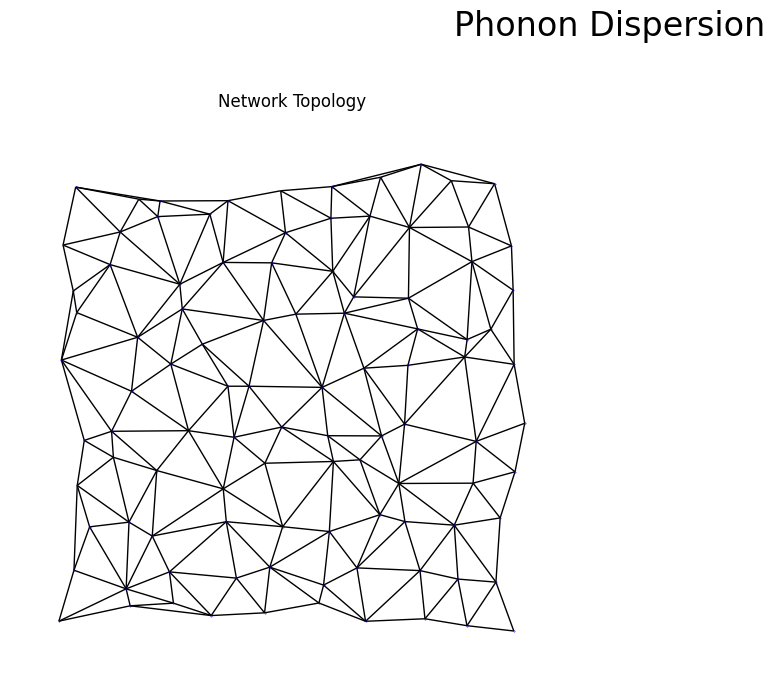

In [7]:
pos = dict(zip(range(N), X))
fig = plt.figure(figsize=(16, 8))
fig.suptitle("Phonon Dispersion", fontsize=24)
ax=plt.subplot(1, 2, 1)
nx.draw(G, pos, node_size=0.1, node_color="blue")
ax.set_aspect('equal')
plt.title("Network Topology")

In [27]:
# Define the system parameters in JAX

# Convert the NetworkX graph into an adjacency matrix
adj_matrix = nx.to_numpy_array(G)

# Convert the adjacency matrix into a JAX MD system
R = np.array(X)  # Coordinates of the points
N = R.shape[0]   # Number of points
species = np.zeros(N, dtype=np.int32)  # All points belong to the same species in this example

# Calculate the maximum extent in each dimension
avg_left = np.mean(R[left_indices], axis=0)
avg_right = np.mean(R[right_indices], axis=0)
avg_bottom = np.mean(R[bottom_indices], axis=0)
avg_top = np.mean(R[top_indices], axis=0)
max_extent = max(avg_right[0] - avg_left[0], avg_top[1] - avg_bottom[1])

# Determine the box length based on the maximum extent and the desired cutoff radius
r_c = 2.0  # Set the desired cutoff radius
box_length = np.max(max_extent) + 1 * r_c

# Define the displacement and shift functions for the periodic system.
displacement, shift = space.free()


In [29]:
max_extent

Array(8.97030543, dtype=float64)

In [32]:
bond_array = E

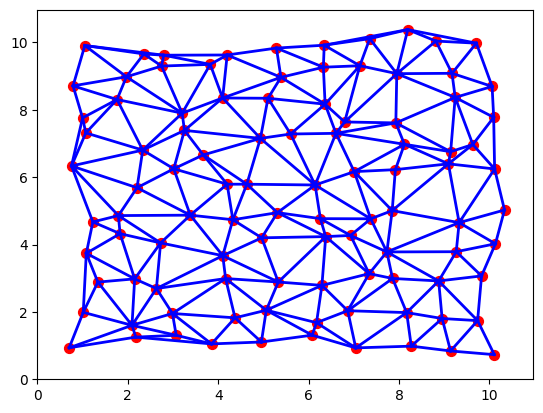

In [33]:
plot_configuration(R, bond_array, box_length)

In [34]:
def harmonic_wall(edge_lower, edge_upper, k, x_lower, x_upper):
    U_lower = 0.5 * k * np.where(edge_lower[:, 0] > x_lower, (edge_lower[:, 0] - x_lower) ** 2, 0)
    U_upper = 0.5 * k * np.where(edge_upper[:, 0] < x_upper, (x_upper - edge_upper[:, 0]) ** 2, 0)
    return np.array(U_lower + U_upper, dtype=edge_lower.dtype)

def total_harmonic_wall_energy(edge_lower, edge_upper, k, x_lower, x_upper):
    return np.sum(harmonic_wall(edge_lower, edge_upper, k=k, x_lower=x_lower, x_upper=x_upper))

def combined_energy_fn(R, E, L, k_bond, k_wall, x_lower, x_upper):
    bond_energy = energy.simple_spring_bond(displacement, E, length=L, epsilon=k_bond)(R)
    wall_energy = total_harmonic_wall_energy(R[left_indices], R[right_indices], k=k_wall, x_lower=x_lower, x_upper=x_upper)
    return bond_energy + wall_energy

def wrapped_energy_fn(R, x_lower=avg_left[0] - 1, x_upper=avg_right[0] + 1, k_wall=1e-3, k_bond=1.0):
    return combined_energy_fn(R, E, L, k_bond=k_bond, k_wall=k_wall, x_lower=x_lower, x_upper=x_upper)

force_fn = quantity.force(wrapped_energy_fn)

In [35]:
print_every = 10
fire_init, fire_apply = minimize.fire_descent(wrapped_energy_fn, shift)
fire_apply = jit(fire_apply)
fire_state = fire_init(R)

E_init = []
traj_init = []

for step in range(100):
  fire_state = fire_apply(fire_state)

  E_init += [wrapped_energy_fn(fire_state.position)]
  traj_init += [fire_state.position]
  if step % print_every == 0:
        R = fire_state.position
        print('{:.2f}\t{:.2f}\t{:.2f}'.format(step, wrapped_energy_fn(R), np.max(force_fn(R))))

R = fire_state.position
#R_init = R
traj_init = np.stack(traj_init)

FireDescentState(position=Array([[ 0.70390069,  0.93417846],
       [ 2.17692885,  1.25127101],
       [ 3.0711199 ,  1.30609956],
       [ 3.852025  ,  1.04991115],
       [ 4.95501654,  1.10633574],
       [ 6.07810742,  1.30956744],
       [ 7.04237532,  0.93164391],
       [ 8.27041192,  0.98342497],
       [ 9.1391591 ,  0.84065101],
       [10.10688436,  0.73090039],
       [ 1.01492565,  1.98679816],
       [ 2.0935615 ,  1.60196728],
       [ 2.98860441,  1.95275738],
       [ 4.37244019,  1.82405598],
       [ 5.06319716,  2.0504519 ],
       [ 6.1746394 ,  1.67978053],
       [ 6.86431018,  2.035145  ],
       [ 8.16815652,  1.97934483],
       [ 8.95260635,  1.80377293],
       [ 9.737323  ,  1.74104444],
       [ 1.33828774,  2.88411034],
       [ 2.15259393,  2.98059703],
       [ 2.63352613,  2.69343924],
       [ 4.16365449,  2.99009921],
       [ 5.32903807,  2.88662662],
       [ 6.29406356,  2.78681135],
       [ 7.33860621,  3.13516494],
       [ 7.85611873,  2.99262

In [ ]:
print_every = 10
fire_init, fire_apply = minimize.fire_descent(wrapped_energy_fn, shift)
fire_apply = jit(fire_apply)
fire_state = fire_init(R)

E_init = []
traj_init = []

for step in range(200):
  fire_state = fire_apply(fire_state)

  E_init += [wrapped_energy_fn(fire_state.position)]
  traj_init += [fire_state.position]
  if step % print_every == 0:
        R = fire_state.position
        print('{:.2f}\t{:.2f}\t{:.2f}'.format(step, wrapped_energy_fn(R), np.max(force_fn(R))))

R = fire_state.position
R_init = R
traj_init = np.stack(traj_init)

In [14]:
compression_amount = 0.1
energy_fn = lambda R: wrapped_energy_fn(R, x_lower=0.0+compression_amount, k_wall=1e-3, k_bond=1.0)
force_fn = quantity.force(energy_fn)
fire_init, fire_apply = minimize.fire_descent(energy_fn, shift)
fire_apply = jit(fire_apply)
fire_state = fire_init(R)

energy_traj = []
traj = []

for step in range(500):
  fire_state = fire_apply(fire_state)

  energy_traj += [energy_fn(fire_state.position)]
  traj += [fire_state.position]
  if step % print_every == 0:
        R = fire_state.position
        print('{:.2f}\t{:.2f}\t{:.2f}'.format(step, energy_fn(R), np.max(force_fn(R))))

R = fire_state.position
traj = np.stack(traj)

0.00	0.02	0.00
10.00	0.02	0.00
20.00	0.02	0.00
30.00	0.02	0.00
40.00	0.02	0.00
50.00	0.02	0.00
60.00	0.02	0.00
70.00	0.02	0.00
80.00	0.02	0.00
90.00	0.02	0.00
100.00	0.02	0.00
110.00	0.02	0.00
120.00	0.02	0.00
130.00	0.02	0.00
140.00	0.02	0.00
150.00	0.02	0.00
160.00	0.02	0.00
170.00	0.02	0.00
180.00	0.02	0.00
190.00	0.02	0.00
200.00	0.02	0.00
210.00	0.02	0.00
220.00	0.02	0.00
230.00	0.02	0.00
240.00	0.02	0.00
250.00	0.02	0.00
260.00	0.02	0.00
270.00	0.02	0.00
280.00	0.02	0.00
290.00	0.02	0.00
300.00	0.02	0.00
310.00	0.02	0.00
320.00	0.02	0.00
330.00	0.02	0.00
340.00	0.02	0.00
350.00	0.02	0.00
360.00	0.02	0.00
370.00	0.02	0.00
380.00	0.02	0.00
390.00	0.02	0.00
400.00	0.02	0.00
410.00	0.02	0.00
420.00	0.02	0.00
430.00	0.02	0.00
440.00	0.02	0.00
450.00	0.02	0.00
460.00	0.02	0.00
470.00	0.02	0.00
480.00	0.02	0.00
490.00	0.02	0.00


In [ ]:
plot_configuration(R, bond_array, box_length)

In [ ]:
fire_init, fire_apply = minimize.fire_descent(wrapped_energy_fn, shift)
fire_apply = jit(fire_apply)
fire_state = fire_init(R)

E = []

for step in range(500):
  fire_state = fire_apply(fire_state)

  E_init += [wrapped_energy_fn(fire_state.position)]
  traj_init += [fire_state.position]
  if step % print_every == 0:
        R = fire_state.position
        print('{:.2f}\t{:.2f}\t{:.2f}'.format(step, wrapped_energy_fn(R), np.max(force_fn(R))))

R = fire_state.position
traj_init = np.stack(traj_init)

In [ ]:

print_every = 10
fire_init, fire_apply = minimize.fire_descent(energy_fn, shift)
fire_apply = jit(fire_apply)
fire_state = fire_init(R)

E_init = []
traj_init = []

for i in range(200):
  fire_state = fire_apply(fire_state)

  E_init += [energy_fn(fire_state.position)]
  traj_init += [fire_state.position]

R = fire_state.position
traj_init = np.stack(traj_init)


# Define the Poisson's ratio calculation function
def poisson_ratio(R):
    # Shift particles along the x-axis
    x_shift = R * np.array([1e-4, 0])

    # Energy minimization
    fire_state = fire_init(x_shift)

    E = []
    traj = []
    print('Minimizing.')
    print('Step\tEnergy\tMax Force')
    print('-----------------------------------')
    for step in range(500):
      fire_state = fire_apply(fire_state)

      E += [energy_fn(fire_state.position)]
      traj += [fire_state.position]
      if step % print_every == 0:
        R_shifted = fire_state.position
        print('{:.2f}\t{:.2f}\t{:.2f}'.format(step, energy_fn(R_shifted), np.max(force_fn(R_shifted))))

    R_shifted = fire_state.position
    traj = np.stack(traj)

    # Calculate the strain tensor components
    exx = (R_shifted[:, 0] - R[:, 0]) / box_length
    eyy = (R_shifted[:, 1] - R[:, 1]) / box_length

    # Calculate the average strain
    exx_avg = np.mean(exx)
    eyy_avg = np.mean(eyy)

    # Calculate the Poisson's ratio
    poisson_ratio = -eyy_avg / exx_avg

    return poisson_ratio, E, traj, R_shifted

# Calculate the Poisson's ratio
poisson_ratio_val, E, traj, R_shifted = poisson_ratio(R)
print("Poisson's ratio:", poisson_ratio_val)

In [ ]:
onp.shape(R)

In [ ]:
plot_configuration(R, bond_array, box_length)

In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Convert the trajectory to a NumPy array
trajectory_array = np.array(traj_init)

# Create a subplot for the scatter plot
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter'}]], print_grid=False)

# Create a scatter plot using Plotly
trace = go.Scatter(x=trajectory_array[:, 0], y=trajectory_array[:, 1], mode='markers')
fig.add_trace(trace)



x_coords = []
y_coords = []

for bond in bond_array:
    node1, node2 = bond
    x_coords.extend([trajectory_array[0][node1, 0], trajectory_array[0][node2, 0], None])
    y_coords.extend([trajectory_array[0][node1, 1], trajectory_array[0][node2, 1], None])

bond_trace = go.Scatter(x=x_coords, y=y_coords, mode='lines', line=dict(width=0.5, color='gray'))
fig.add_trace(bond_trace)


# Create and add slider
steps = []
for i, frame in enumerate(trajectory_array):
    bond_x_coords = []
    bond_y_coords = []
    for bond in bond_array:
        node1, node2 = bond
        bond_x_coords.extend([frame[node1, 0], frame[node2, 0], None])
        bond_y_coords.extend([frame[node1, 1], frame[node2, 1], None])

    step = dict(
        method="update",
        args=[
            {"x": [frame[:, 0], bond_x_coords], "y": [frame[:, 1], bond_y_coords]},
        ],
        label=str(i),
    )
    steps.append(step)

slider = dict(steps=steps, active=0, pad={"t": 50}, currentvalue={"prefix": "Frame: "})

fig.update_layout(sliders=[slider])

# Update the layout
fig.update_layout(
    width=600,
    height=600,
    xaxis=dict(title='X', showgrid=False),
    yaxis=dict(title='Y', showgrid=False),
    plot_bgcolor='rgba(255, 255, 255, 1)', # White background
    margin=dict(l=50, r=50, b=50, t=50) # Adjust margin if needed
)

fig.show()

In [36]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Convert the trajectory to a NumPy array
trajectory_array = np.array(traj_init)

# Create a subplot for the scatter plot
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter'}]], print_grid=False)

# Create a scatter plot using Plotly
trace = go.Scatter(x=trajectory_array[:, 0], y=trajectory_array[:, 1], mode='markers')
fig.add_trace(trace)

# Create and add slider
steps = []
for i, frame in enumerate(trajectory_array):
    step = dict(
        method="update",
        args=[
            {"x": [frame[:, 0]], "y": [frame[:, 1]]},
        ],
        label=str(i),
    )
    steps.append(step)

slider = dict(steps=steps, active=0, pad={"t": 50}, currentvalue={"prefix": "Frame: "})

fig.update_layout(sliders=[slider])

# Update the layout
fig.update_layout(
    width=600,
    height=600,
    xaxis=dict(title='X', showgrid=False),
    yaxis=dict(title='Y', showgrid=False),
    plot_bgcolor='rgba(255, 255, 255, 1)', # White background
    margin=dict(l=50, r=50, b=50, t=50) # Adjust margin if needed
)

fig.show()
